# MY IMPLEMENTATION OF THE SRGAN:
1. In this Implimentation of SRGAN I am leaving out BatchNormalisation as it causes a lot of unwanted problems during model training.
2. I am going to break the image into four parts and pass it to the discriminator as a batch of 4 and I feel like it should work because my device wont be able to compute the whole image at one go. Plus breaking the images into multiple smaller images will result in faster discriminating time.
3. Paper Site: https://arxiv.org/abs/1609.04802
4. DIV2K Dataset Website: https://data.vision.ee.ethz.ch/cvl/DIV2K/


In [3]:
import torch
import torch.nn as nn 
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random

## CHECKING OUT THE DATASET

torch.Size([1356, 2040, 3])


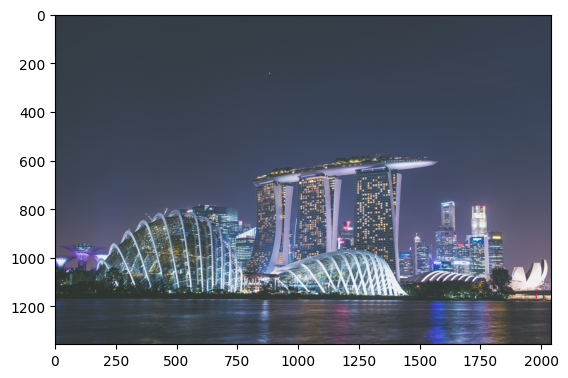

In [15]:
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_HR\DIV2K_valid_HR\0814.png')
img = torch.Tensor(img)
print(img.shape)
plt.imshow(img)

torch.Size([339, 510, 3])


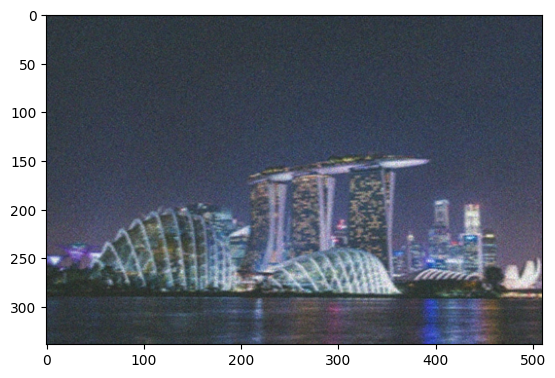

In [16]:
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_LR_difficult\DIV2K_valid_LR_difficult\0814x4d.png')
img = torch.Tensor(img)
print(img.shape)
plt.imshow(img)

torch.Size([339, 510, 3])


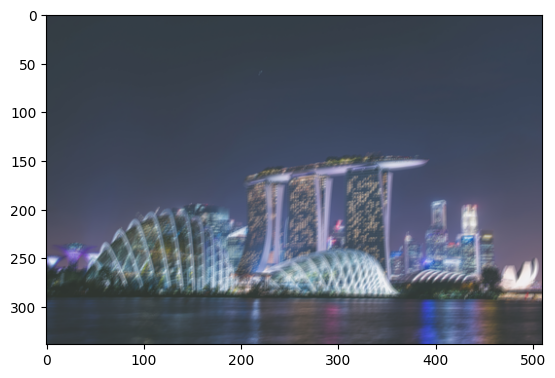

In [17]:
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_LR_unknown_X4\DIV2K_valid_LR_unknown\X4\0814x4.png')
img = torch.Tensor(img)
print(img.shape)
plt.imshow(img)

## Breaking down the images of LR into 4 pieces to make the processing faster

In [18]:
def Image_breakdown(img):
    h = img.shape[1]/2
    w = img.shape[2]/2
    
    if (h-int(h) != 0):
        h1 = int(h - .5)
        h2 = int(h + .5)
    else:
        h1 = int(h)
        h2 = int(h)
    
    if (w-int(w) != 0):
        w1 = int(w - .5)
        w2 = int(w + .5)
    else:
        w1 = int(w)
        w2 = int(w)
        
    top_left = img[ :, :h1, :w1]
    top_right = img[ :, :h1, w1:w1+w2]
    bottom_left = img[ :, h1:h1+h2, :w1]
    bottom_right = img[ :, h1:h1+h2, w1:w1+w2]
    img_mini_batch = [top_left,top_right,bottom_left,bottom_right]
    return img_mini_batch

#### TESTING THE WORKING OF THE BREAKING DOWN OF IMAGES ON THE REAL HIGH RESOLUTION IMAGE

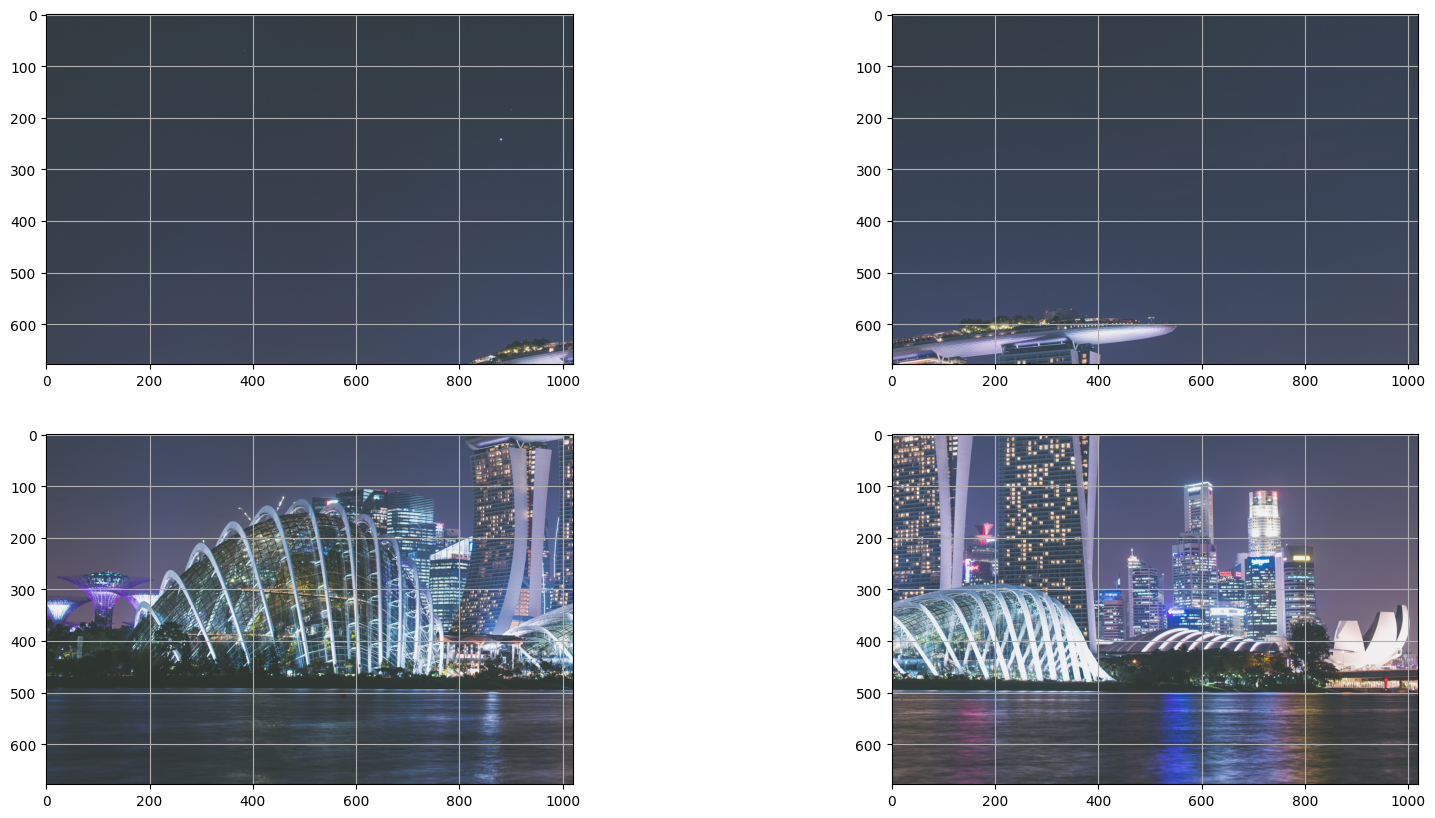

In [19]:
from numpy import expand_dims
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_HR\DIV2K_valid_HR\0814.png')
img = torch.Tensor(img).permute(2,0,1)
x = Image_breakdown(img)
rows = 2
columns = 2
fig = plt.figure(figsize=(20, 10))
for i in range(1,5):
    fig.add_subplot(rows, columns, i)
    x[i-1] = x[i-1].permute(1,2,0)
    x[i-1] = x[i-1].cpu().detach().numpy()
    plt.imshow(x[i-1])
    plt.grid(visible=True)

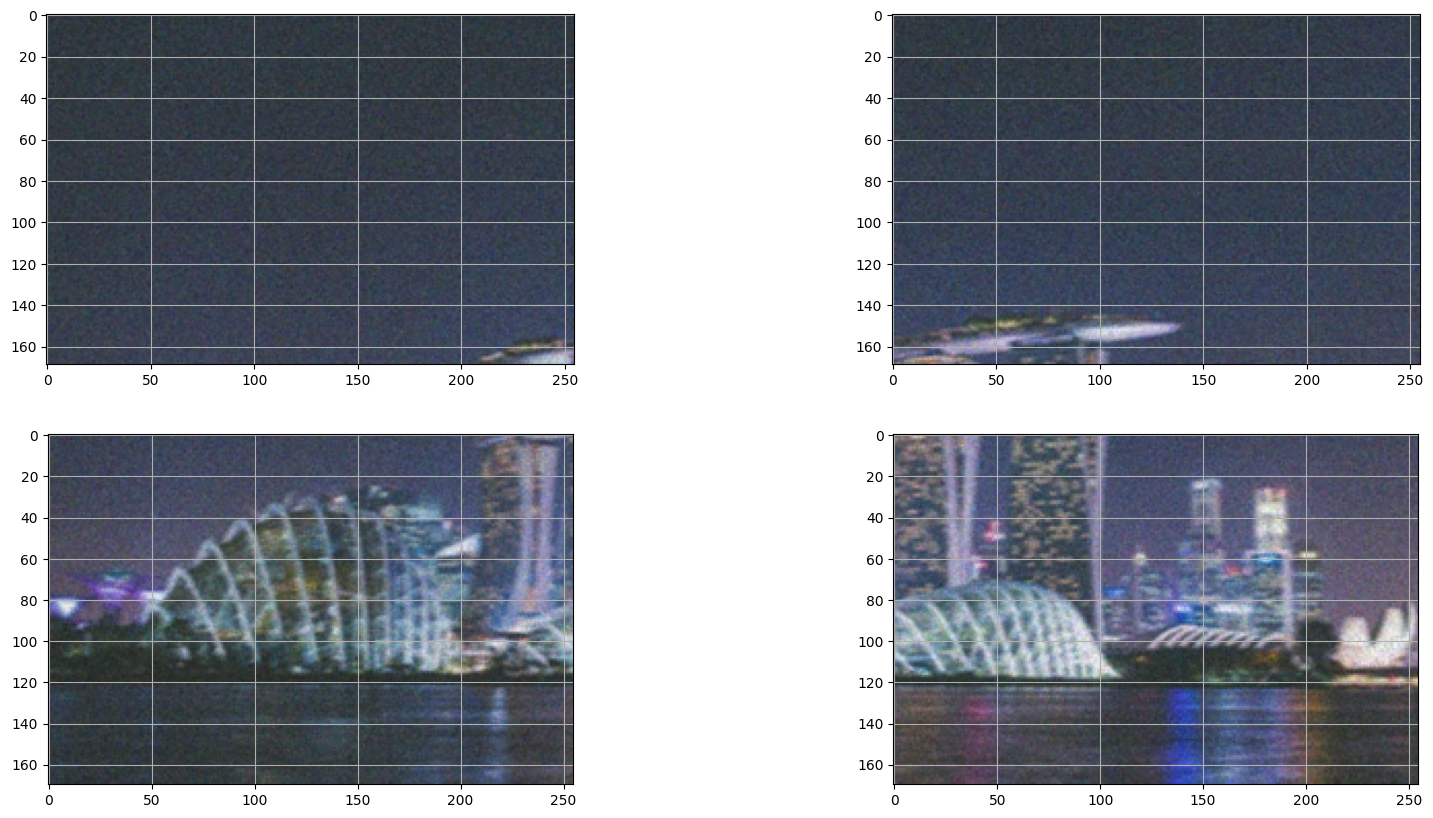

In [20]:
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_LR_difficult\DIV2K_valid_LR_difficult\0814x4d.png')
img = torch.Tensor(img).permute(2,0,1)
x = Image_breakdown(img)
rows = 2
columns = 2
fig = plt.figure(figsize=(20, 10))
for i in range(1,5):
    fig.add_subplot(rows, columns, i)
    x[i-1] = x[i-1].permute(1,2,0)
    x[i-1] = x[i-1].cpu().detach().numpy()
    plt.imshow(x[i-1])
    plt.grid(visible=True)

## **RESIDUAL BLOCK**

In [21]:
class residual_block(nn.Module):
    
    def __init__(self) -> None:
        
        super().__init__()
        
        self.block = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1), nn.PReLU(),
                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1), nn.PReLU())

    def forward(self,x):
        
        x1 = self.block(x)
        x1 = torch.add(x,x1)
        
        return x1

## **GENERATOR**

In [23]:
class generator(nn.Module):
    
    def __init__(self) -> None:
        
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=9,stride=1,padding=4),nn.PReLU())
        self.res1 = residual_block()
        self.res2 = residual_block()
        self.res3 = residual_block()
        self.res4 = residual_block()
        self.res5 = residual_block()
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1))
        self.upscale1 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=256, kernel_size=3, stride=1, padding=1),
                                      nn.PixelShuffle(upscale_factor=2), nn.PReLU())
        self.upscale2 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=256, kernel_size=3, stride=1, padding=1),
                                      nn.PixelShuffle(upscale_factor=2), nn.PReLU())
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=4)
        
    def forward(self,x):
        
        x = self.conv1(x)
        x1 = self.res1(x)
        x1 = self.res2(x1)
        x1 = self.res3(x1)
        x1 = self.res4(x1)
        x1 = self.res5(x1)
        x1 = self.conv2(x1)
        x = torch.add(x,x1)
        x = self.upscale1(x)
        x = self.upscale2(x)
        x = self.conv3(x)
        
        return x       
        

In [24]:
a = torch.rand((4,3,169,255))
a = generator()(a)
a.shape

torch.Size([4, 3, 676, 1020])

## **DISCRIMINATOR**

In [25]:
class discriminator(nn.Module):
    
    def __init__(self) -> None:
        
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1),
                                   nn.LeakyReLU(0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
                                   nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=2,padding=1),
                                   nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                                   nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1),
                                   nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.conv6 = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                                   nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.conv7 = nn.Sequential(nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=2,padding=1),
                                   nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.conv8 = nn.Sequential(nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),
                                   nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        self.conv9 = nn.Sequential(nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=2,padding=1),
                                   nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        self.fc_layer1 = nn.Sequential(nn.Linear(in_features=512*2*2, out_features=1024), nn.LeakyReLU(0.2))
        self.fc_layer2 = nn.Sequential(nn.Linear(in_features=1024, out_features=1), nn.Sigmoid())
        
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = nn.AvgPool2d(kernel_size=(x.shape[2]//2,x.shape[3]//2))(x)
        x = x.view(x.shape[0],512*2*2)
        x = self.fc_layer1(x)
        x = self.fc_layer2(x)
        
        return x

In [26]:
a = torch.rand((4,3,241,510))
a = discriminator()(a)
a.shape

torch.Size([4, 1])

In [24]:
x = []
for i in range(0,100):
    a = random.randint(1,800)
    if i in x:
        i = i-1
    else:
        x.append(a)
x = torch.Tensor(x)
x.unique(return_counts=True)

(tensor([  6.,   8.,  16.,  19.,  27.,  35.,  36.,  39.,  47.,  48.,  49.,  79.,
          81.,  82.,  83.,  85.,  92.,  93., 108., 113., 115., 124., 140., 143.,
         144., 150., 159., 175., 184., 200., 216., 223., 225., 233., 246., 252.,
         276., 283., 284., 304., 323., 346., 356., 357., 388., 409., 416., 420.,
         421., 445., 467., 496., 498., 518., 523., 538., 539., 540., 562., 569.,
         576., 578., 580., 582., 585., 600., 605., 611., 616., 626., 632., 638.,
         677., 680., 687., 688., 700., 731., 742., 749., 762., 769., 776.]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3,
         2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [1]:
def train(num_epochs):
    path_for_train_hr = r"C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_train_HR\DIV2K_train_HR"
    path_for_train_lr = r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_train_LR_difficult\DIV2K_train_LR_difficult'
    for i in range(0,num_epochs):
        x = []
        for i in range(0,100):
            x.append(random.randint(1,800))
        x = torch.Tensor(x)
        for j in range(0,100):
            

IndentationError: expected an indented block (1602227356.py, line 5)